In [1]:
# run under DIP environment
import os
import skimage.io as io
import scipy.io as sio
import numpy as np
import time
# import math

低畫質單通道飛機數據 (含負值) 已生成並保存為 'low_res_airplane_neg_pos.mat'


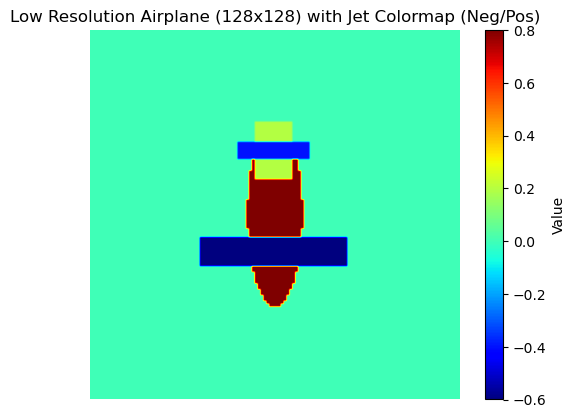

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from PIL import Image # 用於圖像縮放

def generate_airplane_with_negative_values(output_size=(64, 64), filename="airplane_neg_pos_jet.mat"):
    """
    生成一個單通道圖像，其像素值包含負值到正值，
    在繪圖時使用 'jet' colormap 後呈現飛機的樣子，畫質很差，
    並保存為 .mat 檔案。
    """
    # 1. 生成一個簡單的飛機形狀數據 (較高解析度，以便降採樣)
    img_res_high = 256 # 初始較高解析度
    Y_grid, X_grid = np.ogrid[0:img_res_high, 0:img_res_high]

    # 初始化一個全0的陣列作為畫布，現在的值可以是浮點數，包含負值
    # 我們將設定一個範圍，例如 -1.0 到 1.0
    single_channel_image_high_res = np.zeros((img_res_high, img_res_high), dtype=float)

    # --- 機身 (Body) ---
    body_center_x, body_center_y = img_res_high * 0.5, img_res_high * 0.5
    body_width = img_res_high * 0.15
    body_height = img_res_high * 0.5 # 拉長
    
    # 橢圓形的機身
    body_shape = ((X_grid - body_center_x)**2 / (body_width/2)**2 + \
                  (Y_grid - body_center_y)**2 / (body_height/2)**2 <= 1).astype(float)
    
    # 給機身一個正值，例如 0.8
    single_channel_image_high_res[body_shape == 1] = 0.8 

    # --- 機翼 (Wings) ---
    wing_width = img_res_high * 0.4
    wing_height = img_res_high * 0.08
    wing_offset_y = img_res_high * 0.1 # 機翼在機身中心點的上方一點

    # 左翼
    left_wing_x_start = int(body_center_x - wing_width / 2)
    left_wing_x_end = int(body_center_x + wing_width / 2)
    left_wing_y_start = int(body_center_y - wing_height / 2 - wing_offset_y)
    left_wing_y_end = int(body_center_y + wing_height / 2 - wing_offset_y)

    # 給機翼一個負值，例如 -0.6
    single_channel_image_high_res[left_wing_y_start:left_wing_y_end, left_wing_x_start:left_wing_x_end] = -0.6 
    
    # --- 尾翼 (Tail Fins) ---
    tail_width = img_res_high * 0.1
    tail_height = img_res_high * 0.15
    tail_y_offset = img_res_high * 0.35 # 尾翼在機身下部

    # 垂直尾翼 (位於機身後方中央)
    vertical_tail_x_start = int(body_center_x - tail_width / 2)
    vertical_tail_x_end = int(body_center_x + tail_width / 2)
    vertical_tail_y_start = int(body_center_y + body_height / 2 - tail_height)
    vertical_tail_y_end = int(body_center_y + body_height / 2)

    # 給垂直尾翼一個較小的正值，例如 0.2
    single_channel_image_high_res[vertical_tail_y_start:vertical_tail_y_end, vertical_tail_x_start:vertical_tail_x_end] = 0.2 

    # 水平尾翼 (位於垂直尾翼下方兩側)
    horizontal_tail_width = img_res_high * 0.2
    horizontal_tail_height = img_res_high * 0.05
    horizontal_tail_y_offset = img_res_high * 0.05 # 相對於垂直尾翼底部

    horiz_tail_y_start = int(vertical_tail_y_end - horizontal_tail_y_offset - horizontal_tail_height)
    horiz_tail_y_end = int(vertical_tail_y_end - horizontal_tail_y_offset)

    # 給水平尾翼一個負值，例如 -0.4
    horiz_tail_left_x_start = int(body_center_x - horizontal_tail_width / 2)
    horiz_tail_left_x_end = int(body_center_x)
    single_channel_image_high_res[horiz_tail_y_start:horiz_tail_y_end, horiz_tail_left_x_start:horiz_tail_left_x_end] = -0.4

    horiz_tail_right_x_start = int(body_center_x)
    horiz_tail_right_x_end = int(body_center_x + horizontal_tail_width / 2)
    single_channel_image_high_res[horiz_tail_y_start:horiz_tail_y_end, horiz_tail_right_x_start:horiz_tail_right_x_end] = -0.4


    # 2. 降採樣 (降低畫質)
    # 由於PIL的resize操作通常期望0-255或0-1的數據，並且是針對視覺顯示的，
    # 直接用PIL處理帶有負值的浮點數可能不會得到預期的像素化效果。
    # 最好的方法是先將浮點數範圍正規化到 0-255 (或 0-1)，進行縮放，再恢復其原始數值範圍。
    # 或者，更簡潔的做法是直接用 Scipy 的 zoom 函數進行降採樣，它能更好地處理浮點數陣列。
    
    # 這裡我們使用 PIL 的方式，需要先將數據正規化到 0-255，縮放後再反向正規化。
    # 找出數據的最小和最大值
    min_val = np.min(single_channel_image_high_res)
    max_val = np.max(single_channel_image_high_res)
    
    # 將數據正規化到 0-255 範圍 (用於PIL處理)
    # 避免除以零的情況
    if (max_val - min_val) != 0:
        normalized_for_pil = (single_channel_image_high_res - min_val) / (max_val - min_val) * 255
    else:
        normalized_for_pil = np.zeros_like(single_channel_image_high_res) # 如果都是相同值，則全部為0

    pil_img_temp = Image.fromarray(normalized_for_pil.astype(np.uint8))
    
    # 使用最近鄰插值 (Image.NEAREST) 來實現像素化效果
    low_res_pil_img = pil_img_temp.resize(output_size, Image.NEAREST)

    # 轉換回 NumPy 陣列
    low_res_np_img_normalized = np.array(low_res_pil_img)
    
    # 將數據反向正規化回原始的負值到正值範圍
    # 先正規化到 0-1
    low_res_np_img = (low_res_np_img_normalized / 255.0) * (max_val - min_val) + min_val


    # 3. 保存為 .mat 檔案
    # MATLAB 中的影像數據通常是 (高, 寬) 的單通道數據
    mdic = {"airplane_single_channel_neg_pos": low_res_np_img}
    savemat(filename, mdic)

    print(f"低畫質單通道飛機數據 (含負值) 已生成並保存為 '{filename}'")

    # (可選) 顯示圖片以確認效果，使用 jet colormap
    # vmin 和 vmax 參數確保 colormap 正確映射從負值到正值
    plt.imshow(low_res_np_img, cmap='jet', origin='lower', vmin=min_val, vmax=max_val) 
    plt.colorbar(label='Value')
    plt.title(f"Low Resolution Airplane ({output_size[0]}x{output_size[1]}) with Jet Colormap (Neg/Pos)")
    plt.axis('off')
    plt.show()

# 執行函數生成圖片
generate_airplane_with_negative_values(output_size=(128, 128), filename="low_res_airplane_neg_pos.mat")

## Load Data

DD_PARS_blood (from out lab)

In [91]:
# file_name  = 'data\DD_PARS\DD_PARS_blood.mat'
file_name = r"test_RF.mat"
mat = sio.loadmat(file_name)
print(mat.keys())
img_down = mat["test"]
original_x, original_y = img_down.shape
print(original_x, original_y)
print(img_down)



dict_keys(['__header__', '__version__', '__globals__', 'test'])
2200 128
[[ 0. -0.  0. ...  0. -0.  0.]
 [-0. -0.  0. ...  0. -0. -0.]
 [-0. -0.  0. ...  0.  0. -0.]
 ...
 [ 0.  0. -0. ...  0. -0. -0.]
 [ 0. -0. -0. ... -0. -0.  0.]
 [ 0. -0.  0. ... -0. -0.  0.]]


In [93]:
from utils.expand_data import *
img_masked, img_mask = expand_data(img_down, original_x, original_y*2)

Plot the loaded data

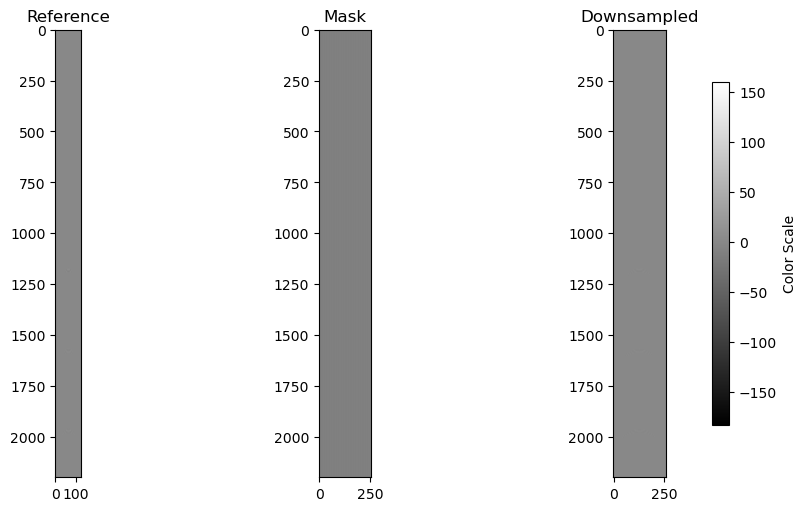

In [105]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

colormap = 'gray'
# plot each image
im1 = axes[0].imshow(img_down, cmap=colormap)
axes[0].set_title("Reference")

im2 = axes[1].imshow(img_mask, cmap = 'gray')
axes[1].set_title("Mask")

im3 = axes[2].imshow(img_masked,cmap=colormap)
axes[2].set_title("Downsampled")

# add colorbars
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Color Scale")

plt.show()


## Pre-work of DIP

In [95]:
import torch
import torch.optim
torch.__version__

'2.0.1'

Set inputs, hyperparameters and network architecture

In [96]:
img_np = np.expand_dims(img_masked, 0)  # expand the downsampled image to 3D numpy array (1, H, W)
mask_np = np.expand_dims(img_mask, 0)   # expand the mask to 3D numpy array (1, H, W)

from models.skip import skip
from utils.inpainting_utils import *

#from skimage.measure import compare_psnr,compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# setup
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.001 
num_iter = 1000
param_noise = False
show_every = 50
save_every = 10
figsize = 5
reg_noise_std = 0.03
    
net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [original_y*2] * 5,
           num_channels_up =   [original_y*2] * 5,
           num_channels_skip =    [4] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='bilinear', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype) # generate a random noise input tensor (1, input_depth, H, W)
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)   # convert numpy array to torch tensor (1, 1, H, W)
mask_var = np_to_torch(mask_np).type(dtype) # convert numpy array to torch tensor (1, 1, H, W)


Number of params: 8727525


Create the numpy to save the reults for each [save_every] iteration and processing time (in second)

In [97]:
out_log_np = np.zeros(shape = (num_iter//save_every, img_masked.shape[0], img_masked.shape[1]))
time_log_np = np.zeros(shape = (1, num_iter//save_every))

show the input noise

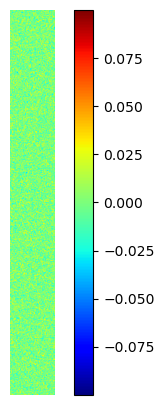

In [98]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(torch_to_np(net_input).transpose(1, 2, 0)[:,:,0], cmap='jet')   
plt.colorbar()

# DIP process

Starting optimization with ADAM


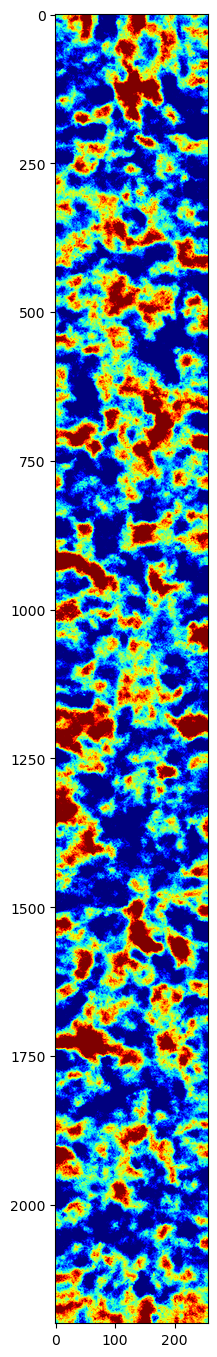

Elasped time:514.962
Elasped time:592.658oss 28.738205    PSNR -14.585633    SSIM 0.064040 
Elasped time:669.447oss 28.730833    PSNR -14.583589    SSIM 0.254481 
Elasped time:746.402oss 28.728554    PSNR -14.583230    SSIM 0.230670 
Elasped time:823.342oss 28.720085    PSNR -14.582021    SSIM 0.167125 


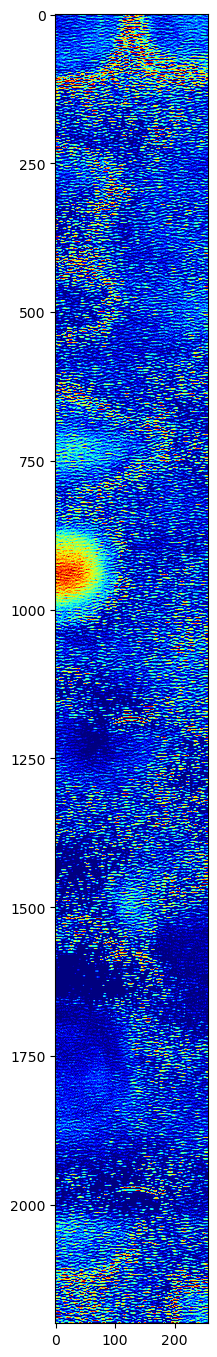

Elasped time:901.02
Elasped time:978.145oss 21.775562    PSNR -14.113153    SSIM 0.002461 
Elasped time:1054.975ss 17.469934    PSNR -14.368192    SSIM 0.005816 
Elasped time:1131.911ss 14.374226    PSNR -14.402647    SSIM 0.004008 
Elasped time:1208.941ss 12.158635    PSNR -14.614600    SSIM 0.002167 


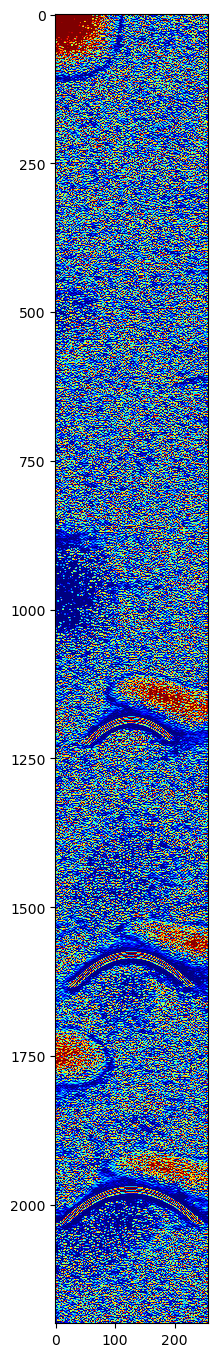

Elasped time:1286.583
Elasped time:1363.536ss 6.625203    PSNR -14.034850    SSIM 0.005429 
Elasped time:1440.484ss 4.613595    PSNR -14.453568    SSIM 0.006494 
Elasped time:1517.304ss 2.995633    PSNR -14.146421    SSIM 0.007838 
Elasped time:1594.434ss 1.998163    PSNR -14.148415    SSIM 0.008845 


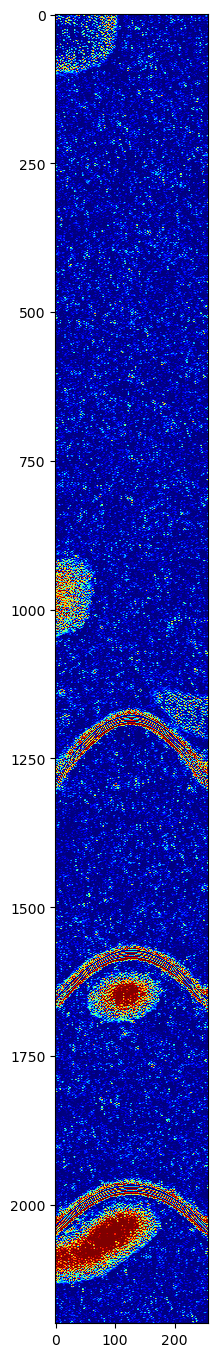

Elasped time:1672.305
Elasped time:1749.267ss 1.028710    PSNR -14.061689    SSIM 0.020987 
Elasped time:1826.526ss 0.870962    PSNR -14.110313    SSIM 0.028442 
Elasped time:1903.597ss 0.707466    PSNR -13.967827    SSIM 0.037751 
Elasped time:1980.59oss 0.600680    PSNR -13.920760    SSIM 0.033599 


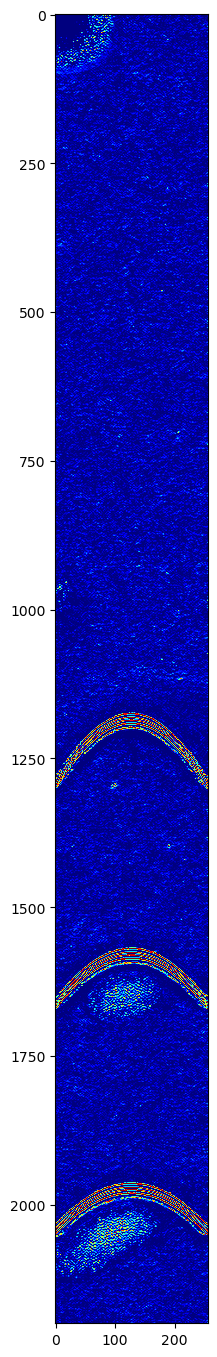

Elasped time:2058.61
Elasped time:2135.759ss 0.509649    PSNR -14.026611    SSIM 0.047362 
Elasped time:2212.825ss 1.156358    PSNR -14.410856    SSIM 0.030259 
Elasped time:2290.069ss 0.715874    PSNR -14.048340    SSIM 0.059983 
Elasped time:2367.247ss 0.495653    PSNR -13.942532    SSIM 0.044346 


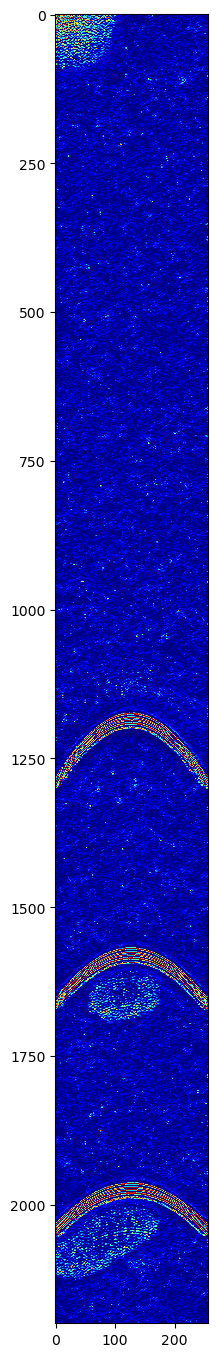

Elasped time:2445.321
Elasped time:2522.543ss 0.384008    PSNR -13.880220    SSIM 0.063861 
Elasped time:2599.822ss 0.396044    PSNR -13.963592    SSIM 0.065863 
Elasped time:2676.901ss 0.367643    PSNR -13.916047    SSIM 0.101803 
Elasped time:2754.343ss 0.393483    PSNR -13.987943    SSIM 0.106883 


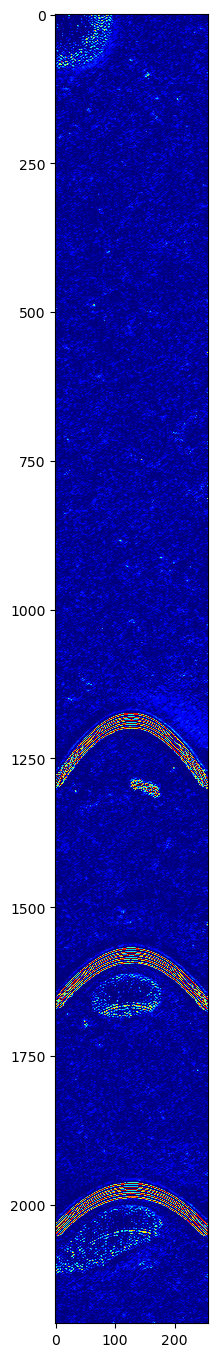

Elasped time:2832.53
Elasped time:2909.696ss 0.294161    PSNR -13.937107    SSIM 0.130975 
Elasped time:2987.255ss 0.275734    PSNR -13.867365    SSIM 0.135224 
Elasped time:3064.811ss 0.274035    PSNR -13.834890    SSIM 0.129427 
Elasped time:3142.487ss 0.270240    PSNR -13.869076    SSIM 0.148857 


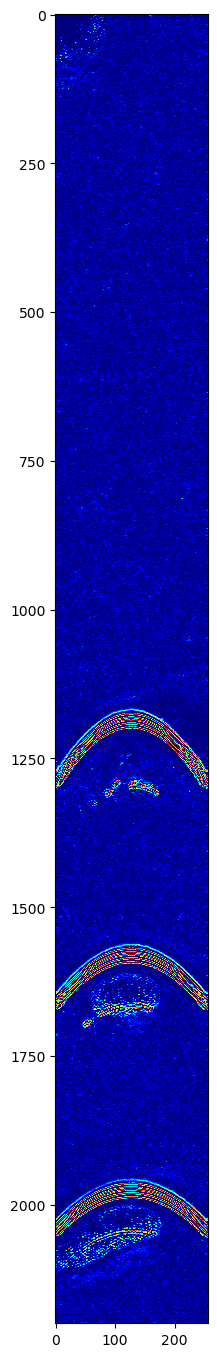

Elasped time:3221.237
Elasped time:3299.137ss 0.240901    PSNR -13.811058    SSIM 0.179293 
Elasped time:3376.949ss 0.246025    PSNR -13.810400    SSIM 0.185803 
Elasped time:3454.938ss 0.240683    PSNR -13.844221    SSIM 0.199373 
Elasped time:3533.243ss 0.227575    PSNR -13.835395    SSIM 0.216778 


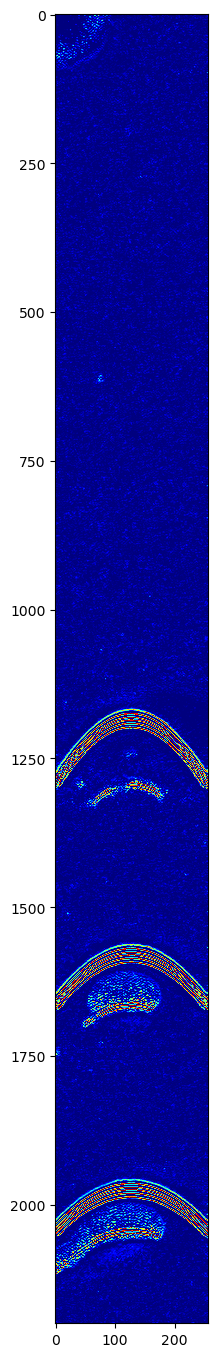

Elasped time:3612.419
Elasped time:3690.85oss 0.206482    PSNR -13.877423    SSIM 0.170162 
Elasped time:3769.012ss 0.192506    PSNR -13.778808    SSIM 0.241455 
Elasped time:3847.145ss 0.195249    PSNR -13.808873    SSIM 0.243592 
Elasped time:3925.342ss 0.217056    PSNR -13.876708    SSIM 0.228791 


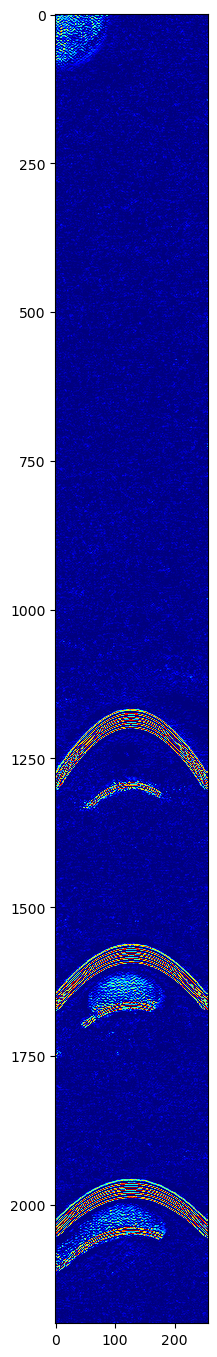

Elasped time:4004.607
Elasped time:4082.993ss 0.178271    PSNR -13.729544    SSIM 0.259796 
Elasped time:4161.212ss 0.161225    PSNR -13.887996    SSIM 0.263377 
Elasped time:4239.387ss 0.164293    PSNR -13.800816    SSIM 0.250895 
Elasped time:4317.625ss 0.158708    PSNR -13.823240    SSIM 0.252799 


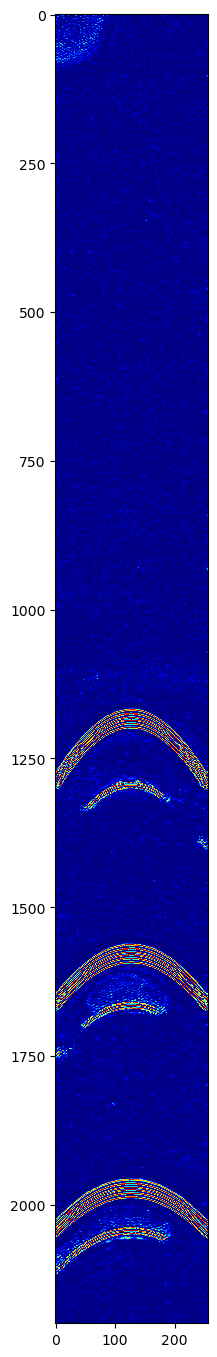

Elasped time:4396.778
Elasped time:4475.129ss 0.146692    PSNR -13.806137    SSIM 0.280898 
Elasped time:4553.512ss 0.155776    PSNR -13.808378    SSIM 0.235853 
Elasped time:4631.756ss 0.145681    PSNR -13.771171    SSIM 0.296617 
Elasped time:4709.979ss 0.135120    PSNR -13.741254    SSIM 0.294784 


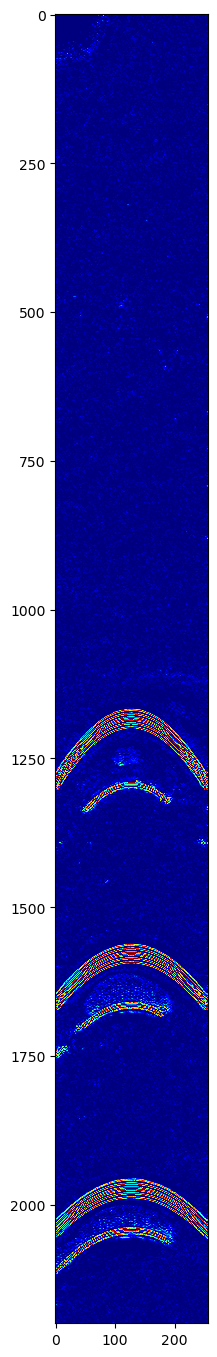

Elasped time:4789.24
Elasped time:4867.614ss 0.145459    PSNR -13.831631    SSIM 0.176267 
Elasped time:4945.942ss 0.143442    PSNR -13.788429    SSIM 0.320193 
Elasped time:5024.133ss 0.138102    PSNR -13.724991    SSIM 0.272962 
Elasped time:5102.433ss 0.148328    PSNR -13.704090    SSIM 0.304230 


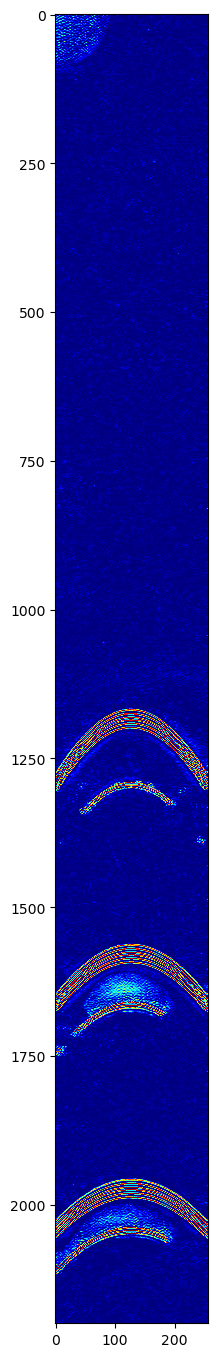

Elasped time:5181.587
Elasped time:5259.915ss 0.122649    PSNR -13.780340    SSIM 0.324773 
Elasped time:5338.521ss 0.124292    PSNR -13.812733    SSIM 0.321675 
Elasped time:5416.749ss 0.114697    PSNR -13.811907    SSIM 0.330884 
Elasped time:5495.03oss 0.110103    PSNR -13.832917    SSIM 0.332969 


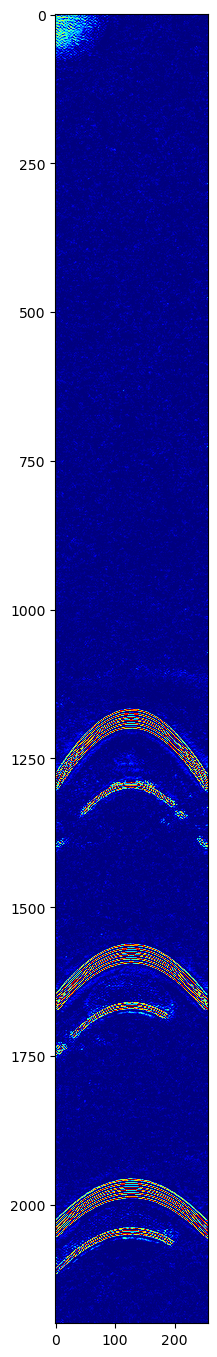

Elasped time:5574.235
Elasped time:5652.637ss 0.229651    PSNR -13.754814    SSIM 0.070548 
Elasped time:5730.993ss 0.717470    PSNR -14.044765    SSIM 0.020729 
Elasped time:5809.4Loss 0.478308    PSNR -13.720225    SSIM 0.019621 
Elasped time:5887.528ss 0.260829    PSNR -13.866629    SSIM 0.107005 


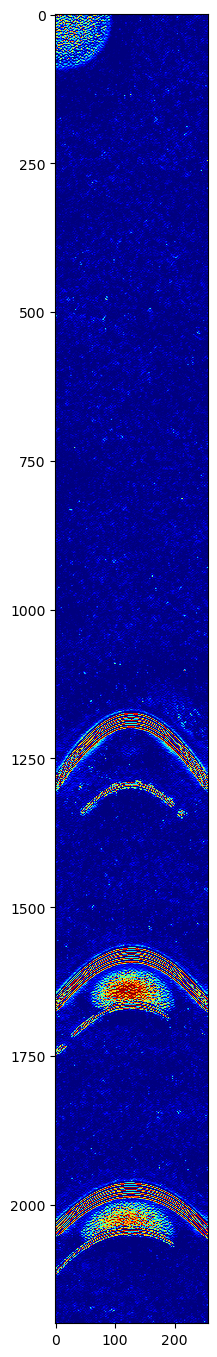

Elasped time:5966.613
Elasped time:6045.06oss 0.166115    PSNR -13.656775    SSIM 0.168666 
Elasped time:6123.409ss 0.144932    PSNR -13.770506    SSIM 0.204222 
Elasped time:6201.759ss 0.138278    PSNR -13.711339    SSIM 0.240747 
Elasped time:6279.981ss 0.133250    PSNR -13.777059    SSIM 0.268921 


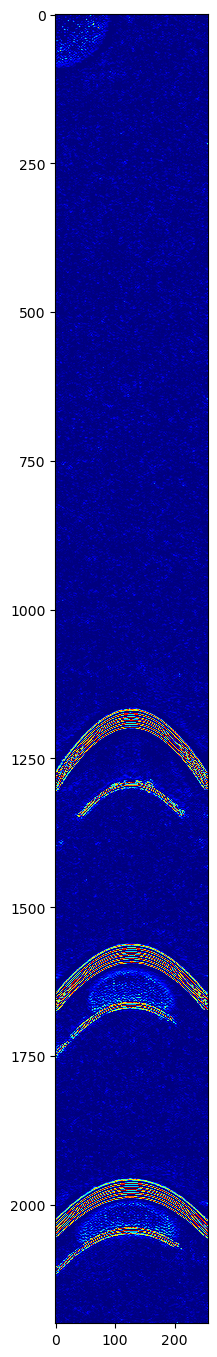

Elasped time:6359.229
Elasped time:6437.493ss 0.124040    PSNR -13.704420    SSIM 0.289511 
Elasped time:6515.894ss 0.121032    PSNR -13.698579    SSIM 0.286390 
Elasped time:6594.285ss 0.111617    PSNR -13.760959    SSIM 0.298684 
Elasped time:6672.691ss 0.170176    PSNR -13.713738    SSIM 0.278570 


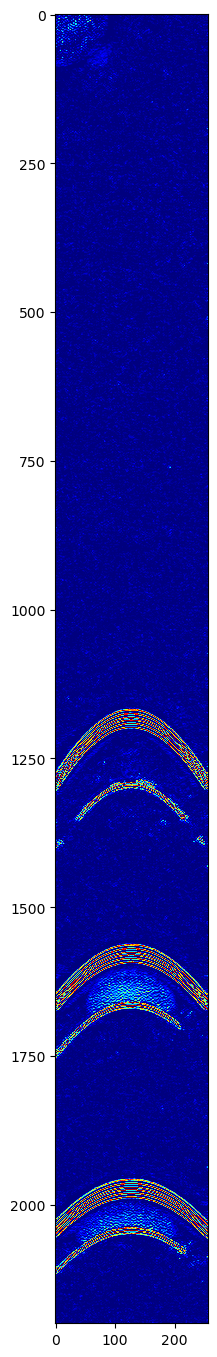

Elasped time:6752.043
Elasped time:6830.375ss 0.101380    PSNR -13.708480    SSIM 0.345532 
Elasped time:6908.788ss 0.098735    PSNR -13.770310    SSIM 0.344325 
Elasped time:6987.226ss 0.098425    PSNR -13.695619    SSIM 0.357406 
Elasped time:7065.687ss 0.098746    PSNR -13.768829    SSIM 0.341224 


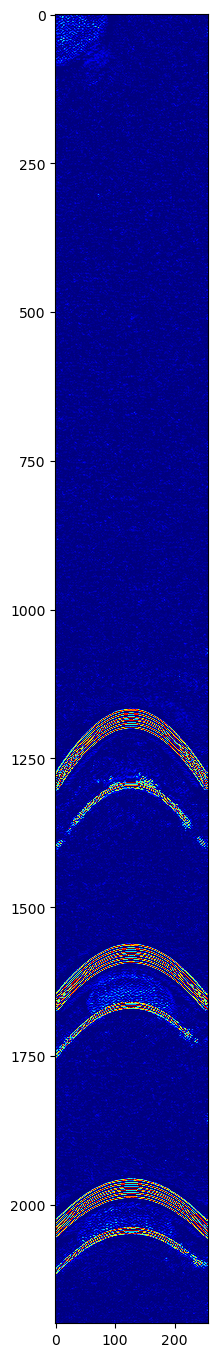

Elasped time:7144.869
Elasped time:7223.178ss 0.088500    PSNR -13.737927    SSIM 0.351587 
Elasped time:7301.549ss 0.087639    PSNR -13.704479    SSIM 0.364394 
Elasped time:7379.972ss 0.093912    PSNR -13.669639    SSIM 0.367832 
Elasped time:7458.461ss 0.085975    PSNR -13.687825    SSIM 0.377181 


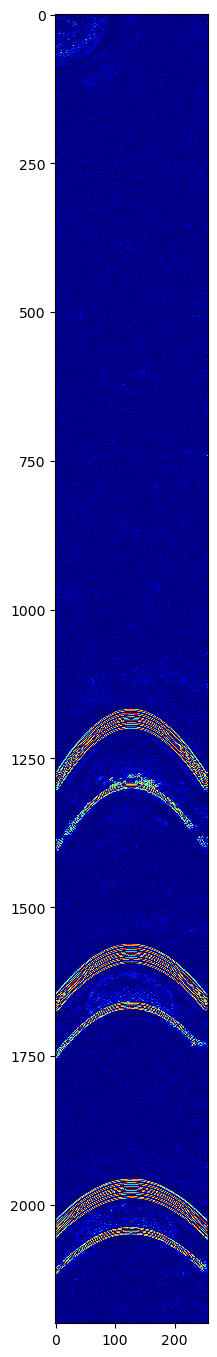

Elasped time:7537.705
Elasped time:7615.924ss 0.080462    PSNR -13.734893    SSIM 0.391849 
Elasped time:7694.058ss 0.100090    PSNR -13.739206    SSIM 0.365591 
Elasped time:7772.445ss 0.082975    PSNR -13.726739    SSIM 0.379911 
Elasped time:7850.952ss 0.073384    PSNR -13.760222    SSIM 0.391020 


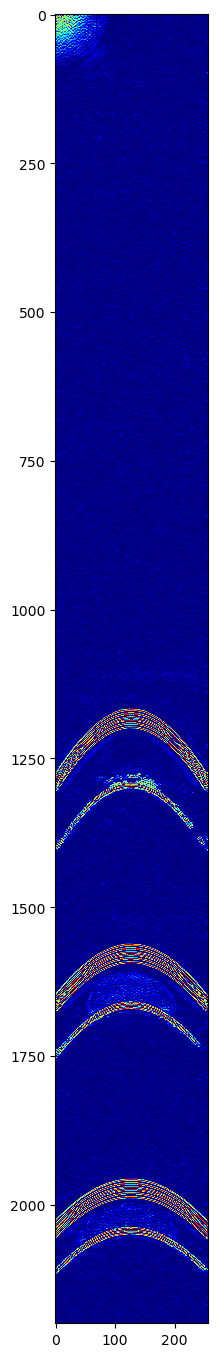

Elasped time:7930.189
Elasped time:8008.555ss 0.083709    PSNR -13.757144    SSIM 0.411518 
Elasped time:8086.705ss 0.078739    PSNR -13.725209    SSIM 0.408238 
Elasped time:8165.208ss 0.076095    PSNR -13.721470    SSIM 0.419723 
Elasped time:8243.551ss 0.076622    PSNR -13.712812    SSIM 0.423221 


In [99]:
i = 0
psnr_history = [] 
loss_history = [] 
ssim_history = []
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)    # output of network (1, 1, H, W)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    psnr = compare_psnr(img_np, torch_to_np(out), data_range = 1.0)
    ssim = compare_ssim(img_np[0,:], torch_to_np(out)[0,:], data_range = 1.0)
    # History
    loss_history.append(total_loss.item())
    psnr_history.append(psnr)
    ssim_history.append(ssim)

    print ('Iteration %05d    Loss %f    PSNR %f    SSIM %f' % (i, total_loss.item(), psnr, ssim), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)   
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
    if i % save_every == 0:
        out_np = torch_to_np(out)[0,:]
        out_log_np[i//save_every, :, :] = out_np
        print(f'Elasped time:{round(time.time() - start_time, 3)}')
        time_log_np[0, i//save_every] = round(time.time() - start_time, 3)
    i += 1
    return total_loss

start_time = time.time()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Show the final output of DIP

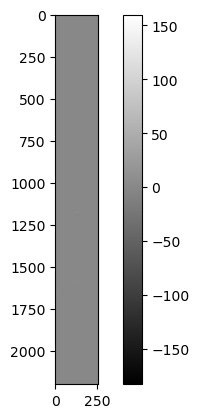

In [107]:
img_out = torch_to_np(net(net_input))[0,:]
plt.imshow(img_out, cmap='gray')
plt.colorbar()

Text(0.5, 1.0, 'Reconstructed')

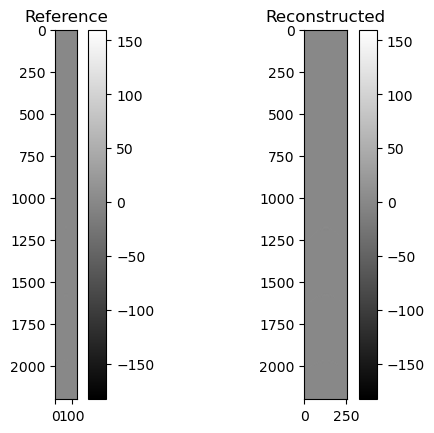

In [101]:
plt.subplot(1, 2, 1)
plt.imshow(img_down, cmap='gray')
plt.colorbar()
plt.title('Reference')
plt.subplot(1, 2, 2)
plt.imshow(img_out, cmap='gray')
plt.colorbar()
plt.title('Reconstructed')

In [102]:
print(f'Reference minimum: \t{img_down.min()},\tmaximum: {img_down.max()}')
print(f'Reconstructed minimum: \t{img_out.min()},\tmaximum: {img_out.max()}')

Reference minimum: 	-182.82730102539062,	maximum: 160.0046844482422
Reconstructed minimum: 	-182.70217895507812,	maximum: 159.96310424804688


In [46]:
torch.cuda.empty_cache()

In [103]:
savemat("reconstruct.mat", {"result":img_out})